In [1]:
# %% [markdown]
# # Model Training - ripenessVision
# 
# Training model dengan transfer learning untuk deteksi kematangan buah

# %%
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image

In [2]:
# %%
# Setup
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data' / 'raw'
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'
MODELS_DIR = BASE_DIR / 'models'
RESULTS_DIR = BASE_DIR / 'results'

MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


In [3]:
# %%
# Configuration
config = {
    'img_size': (224, 224),
    'batch_size': 32,
    'epochs': 50,
    'num_classes': 9,  # 3 fruits × 3 ripeness levels
    'learning_rate': 1e-4,
    'model_name': 'MobileNetV2'
}


In [4]:
# %%
# Load metadata
train_df = pd.read_csv(PROCESSED_DIR / 'train_metadata.csv')
val_df = pd.read_csv(PROCESSED_DIR / 'val_metadata.csv')
test_df = pd.read_csv(PROCESSED_DIR / 'test_metadata.csv')

with open(PROCESSED_DIR / 'data_splits.json', 'r') as f:
    split_info = json.load(f)

classes = split_info['classes']
class_mapping = split_info['class_mapping']

print(f"Classes: {classes}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Classes: ['tomato_unripe', 'tomato_ripe', 'tomato_overripe', 'mango_unripe', 'mango_ripe', 'mango_overripe', 'banana_unripe', 'banana_ripe', 'banana_overripe']
Training samples: 555
Validation samples: 119
Test samples: 120


In [5]:
# %%
# Filter valid image files dengan approach yang lebih robust
def filter_valid_images(df):
    """Filter out invalid image files dengan comprehensive checking"""
    valid_files = []
    invalid_files = []
    
    for idx, row in df.iterrows():
        file_path = row['file_path']
        
        # Check 1: File exists
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            invalid_files.append(file_path)
            continue
            
        # Check 2: File size > 0
        if os.path.getsize(file_path) == 0:
            print(f"Empty file: {file_path}")
            invalid_files.append(file_path)
            continue
            
        # Check 3: Valid image extension
        valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
        file_ext = os.path.splitext(file_path)[1].lower()
        if file_ext not in valid_extensions:
            print(f"Invalid extension: {file_path}")
            invalid_files.append(file_path)
            continue
            
        # Check 4: Can be opened and verified as image
        try:
            with Image.open(file_path) as img:
                img.verify()  # Verify it's an image
                # Additional check: try to convert to array
                img_array = np.array(img)
                if img_array.size == 0:
                    raise ValueError("Empty image array")
                    
            valid_files.append(idx)
            
        except (IOError, SyntaxError, OSError, ValueError, Exception) as e:
            print(f"Corrupt image: {file_path} - Error: {str(e)}")
            invalid_files.append(file_path)
            continue
    
    print(f"Valid files: {len(valid_files)}, Invalid files: {len(invalid_files)}")
    return df.loc[valid_files]

In [6]:
# %%
# Apply filtering
print("Filtering training data...")
train_df = filter_valid_images(train_df)
print("Filtering validation data...")
val_df = filter_valid_images(val_df)
print("Filtering test data...")
test_df = filter_valid_images(test_df)

print(f"After filtering - Training: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Filtering training data...
Corrupt image: ..\data\raw\banana\unripe\unripe_banana_high_quality_photo_98.jpg - Error: cannot identify image file '..\\data\\raw\\banana\\unripe\\unripe_banana_high_quality_photo_98.jpg'
Corrupt image: ..\data\raw\mango\overripe\overripe_mango_high_quality_photo_25.jpg - Error: cannot identify image file '..\\data\\raw\\mango\\overripe\\overripe_mango_high_quality_photo_25.jpg'
Corrupt image: ..\data\raw\mango\unripe\unripe_mango_high_quality_photo_46.jpg - Error: cannot identify image file '..\\data\\raw\\mango\\unripe\\unripe_mango_high_quality_photo_46.jpg'
Corrupt image: ..\data\raw\banana\overripe\overripe_banana_high_quality_photo_38.jpg - Error: cannot identify image file '..\\data\\raw\\banana\\overripe\\overripe_banana_high_quality_photo_38.jpg'
Corrupt image: ..\data\raw\banana\overripe\overripe_banana_high_quality_photo_45.jpg - Error: cannot identify image file '..\\data\\raw\\banana\\overripe\\overripe_banana_high_quality_photo_45.jpg'
Corrupt

In [7]:
# %%
# Save filtered dataframes
train_df.to_csv(PROCESSED_DIR / 'train_metadata_filtered.csv', index=False)
val_df.to_csv(PROCESSED_DIR / 'val_metadata_filtered.csv', index=False)
test_df.to_csv(PROCESSED_DIR / 'test_metadata_filtered.csv', index=False)

In [8]:
# %%
# Create custom data generator yang handle corrupt images
class SafeDataGenerator:
    """Custom data generator yang skip corrupt images"""
    
    def __init__(self, dataframe, datagen, target_size=(224, 224), batch_size=32, shuffle=True):
        self.dataframe = dataframe.reset_index(drop=True)
        self.datagen = datagen
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.classes = sorted(dataframe['class'].unique())
        self.n = len(dataframe)
        self.indices = np.arange(self.n)
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __iter__(self):
        return self
    
    def __next__(self):
        batch_images = []
        batch_labels = []
        
        while len(batch_images) < self.batch_size:
            if self.current_index >= self.n:
                if len(batch_images) == 0:
                    raise StopIteration
                break
                
            idx = self.indices[self.current_index]
            self.current_index += 1
            
            row = self.dataframe.iloc[idx]
            file_path = row['file_path']
            class_name = row['class']
            
            try:
                # Load and preprocess image
                img = keras.preprocessing.image.load_img(
                    file_path, target_size=self.target_size
                )
                img_array = keras.preprocessing.image.img_to_array(img)
                img_array = self.datagen.standardize(img_array)
                
                # Convert label to categorical
                label_index = self.classes.index(class_name)
                label = tf.keras.utils.to_categorical(label_index, len(self.classes))
                
                batch_images.append(img_array)
                batch_labels.append(label)
                
            except Exception as e:
                print(f"Skipping corrupt image: {file_path} - Error: {e}")
                continue
        
        if len(batch_images) == 0:
            raise StopIteration
            
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        self.current_index = 0
        if self.shuffle:
            np.random.shuffle(self.indices)


In [9]:
# %%
# Create standard data generators dengan error handling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,      # DITINGKATKAN
    width_shift_range=0.3,  # DITINGKATKAN  
    height_shift_range=0.3, # DITINGKATKAN
    shear_range=0.3,        # DITINGKATKAN
    zoom_range=0.3,         # DITINGKATKAN
    horizontal_flip=True,
    vertical_flip=True,     # TAMBAH INI
    brightness_range=[0.5, 1.5],  # PERBESAR RANGE
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# %%
# Function untuk create data generator dengan safe mode
def create_safe_data_generator(df, datagen, target_size=(224, 224), batch_size=32, shuffle=True):
    """Create data generator dengan handling corrupt images"""
    
    # Filter valid images terlebih dahulu
    valid_df = filter_valid_images(df)
    
    print(f"Creating generator with {len(valid_df)} valid images")
    
    # Create generator dengan parameter yang lebih strict
    generator = datagen.flow_from_dataframe(
        valid_df,
        x_col='file_path',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle,
        classes=classes
    )
    
    return generator

In [11]:
# %%
# Create data generators
print("Creating training generator...")
train_generator = create_safe_data_generator(
    train_df, train_datagen, 
    target_size=config['img_size'], 
    batch_size=config['batch_size'], 
    shuffle=True
)

print("Creating validation generator...")
val_generator = create_safe_data_generator(
    val_df, val_datagen,
    target_size=config['img_size'],
    batch_size=config['batch_size'],
    shuffle=False
)

print("Creating test generator...")
test_generator = create_safe_data_generator(
    test_df, val_datagen,
    target_size=config['img_size'],
    batch_size=config['batch_size'],
    shuffle=False
)

Creating training generator...
Valid files: 536, Invalid files: 0
Creating generator with 536 valid images
Found 536 validated image filenames belonging to 9 classes.
Creating validation generator...
Valid files: 112, Invalid files: 0
Creating generator with 112 valid images
Found 112 validated image filenames belonging to 9 classes.
Creating test generator...
Valid files: 117, Invalid files: 0
Creating generator with 117 valid images
Found 117 validated image filenames belonging to 9 classes.


In [12]:
# %%
# Display sample batch dengan improved error handling
def show_sample_batch(generator):
    max_attempts = 3
    for attempt in range(max_attempts):
        try:
            x_batch, y_batch = next(generator)
            
            fig, axes = plt.subplots(4, 8, figsize=(15, 8))
            batch_size = len(x_batch)
            
            for i in range(min(32, batch_size)):
                row = i // 8
                col = i % 8
                axes[row, col].imshow(x_batch[i])
                class_idx = np.argmax(y_batch[i])
                class_name = classes[class_idx]
                axes[row, col].set_title(class_name, fontsize=8)
                axes[row, col].axis('off')
            
            # Hide empty subplots
            for i in range(batch_size, 32):
                row = i // 8
                col = i % 8
                axes[row, col].axis('off')
            
            plt.tight_layout()
            plt.show()
            break  # Success, break out of attempts loop
            
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt == max_attempts - 1:
                print("Failed to display batch after multiple attempts")
                # Show available classes instead
                print("Available classes in generator:", list(generator.class_indices.keys()))
                return

Sample training batch:


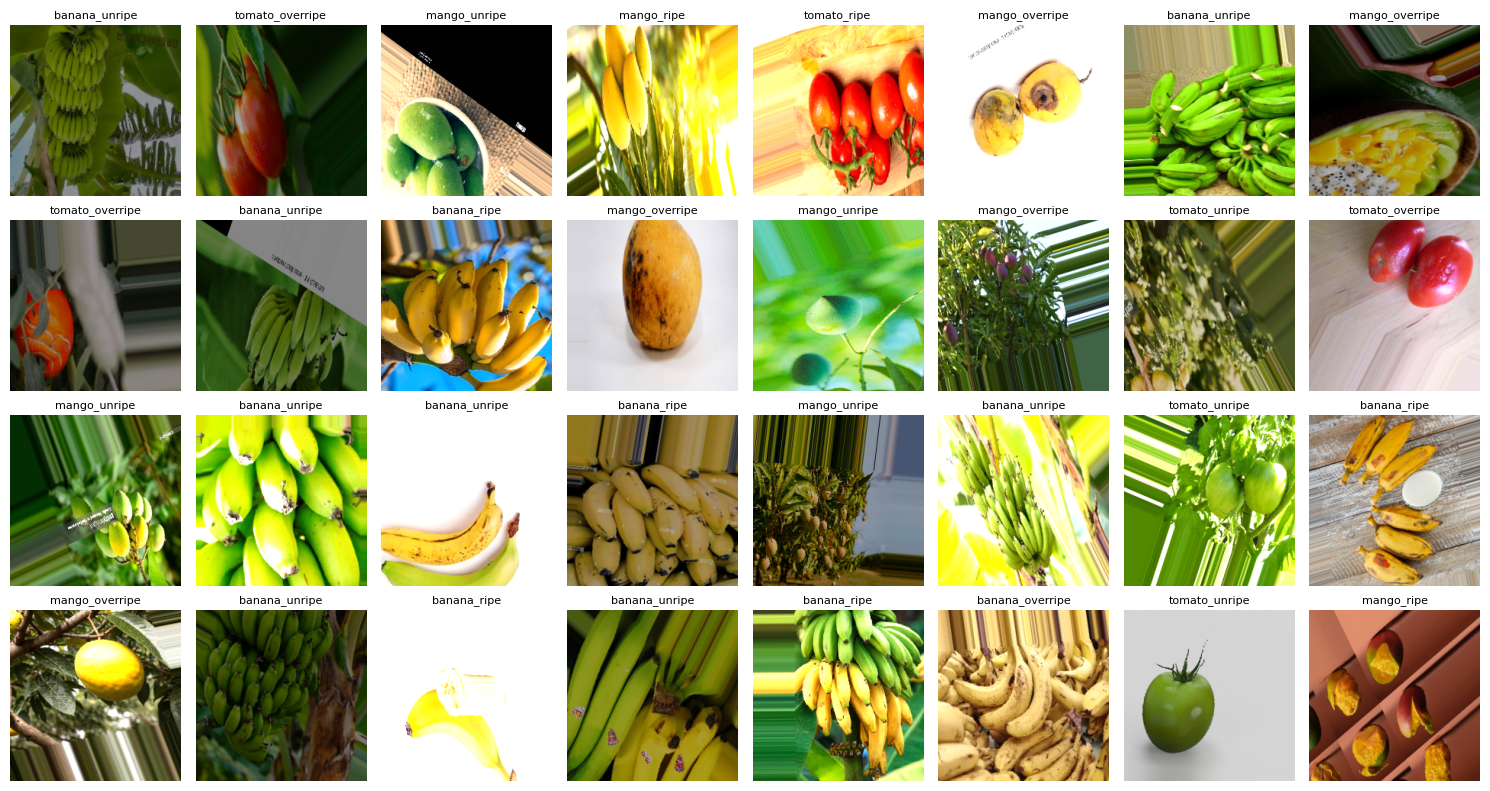

In [13]:
# %%
print("Sample training batch:")
show_sample_batch(train_generator)

In [14]:
# %%
# Model building function
def build_model(base_model_name='MobileNetV2'):
    # Create base model
    input_shape = config['img_size'] + (3,)  # Pastikan 3 channel untuk RGB
    
    if base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    #elif base_model_name == 'EfficientNetB0':
     #   base_model = EfficientNetB0(
      #      weights='imagenet',
       #     include_top=False,
        #    input_shape=input_shape
        #)
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}")
    
    # Freeze base model
    base_model.trainable = False
    
    # Add custom head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(config['num_classes'], activation='softmax')
    ])
    
    return model, base_model

In [15]:
# %%
# Build model
model, base_model = build_model(config['model_name'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,050,569 (11.64 MB)

 Trainable params: 791,049 (3.02 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

In [16]:
# %%
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
# %%
# Callbacks
callbacks = [
    ModelCheckpoint(
        str(MODELS_DIR / 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]


In [18]:
# %%
# Phase 1: Train only the head
print("=== PHASE 1: Training the head ===")
history1 = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

=== PHASE 1: Training the head ===


c:\Users\Admin\Documents\Projek AI\ripeness\ripenessvision\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1246 - loss: 3.0021
Epoch 1: val_accuracy improved from None to 0.26786, saving model to ..\models\best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 161s 7s/step - accuracy: 0.1493 - loss: 2.8702 - val_accuracy: 0.2679 - val_loss: 2.1051 - learning_rate: 1.0000e-04
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2125 - loss: 2.4511
Epoch 2: val_accuracy improved from 0.26786 to 0.35714, saving model to ..\models\best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step - accuracy: 0.2183 - loss: 2.4161 - val_accuracy: 0.3571 - val_loss: 1.8860 - learning_rate: 1.0000e-04
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2351 - loss: 2.4092
Epoch 3: val_accuracy improved from 0.35714 to 0.46429, saving model to ..\models\best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 134s 7s/step - accuracy: 0.2593 - loss: 2.3084 - val_accuracy: 0.4643 - val_loss: 1.7020 - learning_rate: 1.0000e-04
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3231 - loss: 1.9827
Epoch 4: val_accuracy improved from 0.46429 to 0.54464, saving model to ..\models\best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.2836 - loss: 2.0682 - val_accuracy: 0.5446 - val_loss: 1.5577 - learning_rate: 1.0000e-04
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3842 - loss: 1.7683
Epoch 5: val_accuracy did not improve from 0.54464
17/17 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.3806 - loss: 1.8236 - val_accuracy: 0.5357 - val_loss: 1.4401 - learning_rate: 1.0000e-04
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4350 - loss: 1.8587
Epoch 6: val_accuracy did not improve from 0.54464
17/17 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.4198 - loss: 1.8080 - val_accuracy: 0.5446 - val_loss: 1.3460 - learning_rate: 1.0000e-04
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.4346 - loss: 1.6456 
Epoch 7: val_accuracy improved from 0.54464 to 0.58036, saving model to ..\models\best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 306s 16s/step - accuracy: 0.4142 - loss: 1.7008 - val_accuracy: 0.5804 - val_loss: 1.2669 - learning_rate: 1.0000e-04
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4336 - loss: 1.6457 
Epoch 8: val_accuracy did not improve from 0.58036
17/17 ━━━━━━━━━━━━━━━━━━━━ 202s 12s/step - accuracy: 0.4664 - loss: 1.5989 - val_accuracy: 0.5625 - val_loss: 1.2046 - learning_rate: 1.0000e-04
Epoch 9/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4539 - loss: 1.5359 
Epoch 9: val_accuracy improved from 0.58036 to 0.59821, saving model to ..\models\best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 208s 12s/step - accuracy: 0.4571 - loss: 1.5226 - val_accuracy: 0.5982 - val_loss: 1.1493 - learning_rate: 1.0000e-04
Epoch 10/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4700 - loss: 1.4221
Epoch 10: val_accuracy improved from 0.59821 to 0.60714, saving model to ..\models\best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 213s 12s/step - accuracy: 0.4590 - loss: 1.4940 - val_accuracy: 0.6071 - val_loss: 1.1128 - learning_rate: 1.0000e-04
Epoch 11/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5034 - loss: 1.4468
Epoch 11: val_accuracy did not improve from 0.60714
17/17 ━━━━━━━━━━━━━━━━━━━━ 172s 10s/step - accuracy: 0.5205 - loss: 1.4412 - val_accuracy: 0.5804 - val_loss: 1.0768 - learning_rate: 1.0000e-04
Epoch 12/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5058 - loss: 1.4334
Epoch 12: val_accuracy did not improve from 0.60714
17/17 ━━━━━━━━━━━━━━━━━━━━ 154s 9s/step - accuracy: 0.5261 - loss: 1.3886 - val_accuracy: 0.5982 - val_loss: 1.0533 - learning_rate: 1.0000e-04
Epoch 13/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5043 - loss: 1.3168 
Epoch 13: val_accuracy improved from 0.60714 to 0.61607, saving model to ..\models\best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 271s 13s/step - accuracy: 0.4907 - loss: 1.3560 - val_accuracy: 0.6161 - val_loss: 1.0289 - learning_rate: 1.0000e-04
Epoch 14/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5762 - loss: 1.2687
Epoch 14: val_accuracy did not improve from 0.61607
17/17 ━━━━━━━━━━━━━━━━━━━━ 184s 10s/step - accuracy: 0.5522 - loss: 1.2379 - val_accuracy: 0.6161 - val_loss: 1.0102 - learning_rate: 1.0000e-04
Epoch 15/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5227 - loss: 1.2863 
Epoch 15: val_accuracy did not improve from 0.61607
17/17 ━━━━━━━━━━━━━━━━━━━━ 205s 12s/step - accuracy: 0.5373 - loss: 1.2858 - val_accuracy: 0.6161 - val_loss: 0.9972 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.


In [19]:
# %%
# Phase 2: Fine-tuning
print("=== PHASE 2: Fine-tuning ===")

# Unfreeze base model layers
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers) // 2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config['learning_rate'] / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

=== PHASE 2: Fine-tuning ===


In [20]:
# %%
# Continue training
history2 = model.fit(
    train_generator,
    epochs=config['epochs'],
    initial_epoch=history1.epoch[-1] + 1,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 16/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.3987 - loss: 1.7139 
Epoch 16: val_accuracy improved from 0.61607 to 0.64286, saving model to ..\models\best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 500s 20s/step - accuracy: 0.4104 - loss: 1.7422 - val_accuracy: 0.6429 - val_loss: 0.9960 - learning_rate: 1.0000e-05
Epoch 17/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.3973 - loss: 1.6490 
Epoch 17: val_accuracy did not improve from 0.64286
17/17 ━━━━━━━━━━━━━━━━━━━━ 310s 18s/step - accuracy: 0.4067 - loss: 1.6598 - val_accuracy: 0.6429 - val_loss: 0.9998 - learning_rate: 1.0000e-05
Epoch 18/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4305 - loss: 1.6654
Epoch 18: val_accuracy improved from 0.64286 to 0.66071, saving model to ..\models\best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 184s 10s/step - accuracy: 0.4422 - loss: 1.6470 - val_accuracy: 0.6607 - val_loss: 1.0038 - learning_rate: 1.0000e-05
Epoch 19/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4432 - loss: 1.6341
Epoch 19: val_accuracy did not improve from 0.66071
17/17 ━━━━━━━━━━━━━━━━━━━━ 167s 10s/step - accuracy: 0.4422 - loss: 1.5947 - val_accuracy: 0.6518 - val_loss: 1.0148 - learning_rate: 1.0000e-05
Epoch 20/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4342 - loss: 1.6726
Epoch 20: val_accuracy did not improve from 0.66071
17/17 ━━━━━━━━━━━━━━━━━━━━ 195s 9s/step - accuracy: 0.4086 - loss: 1.6942 - val_accuracy: 0.6339 - val_loss: 1.0236 - learning_rate: 1.0000e-05
Epoch 21/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4198 - loss: 1.6112
Epoch 21: val_accuracy did not improve from 0.66071

Epoch 21: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
17/17 ━━━━━━━━━━━━━━━━━━━━ 201s 9s/step - accuracy: 0.4403 - loss: 1.6199 - val

In [29]:
# %%
# Combine histories
def combine_histories(history1, history2):
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key]
    return combined_history

combined_history = combine_histories(history1, history2)

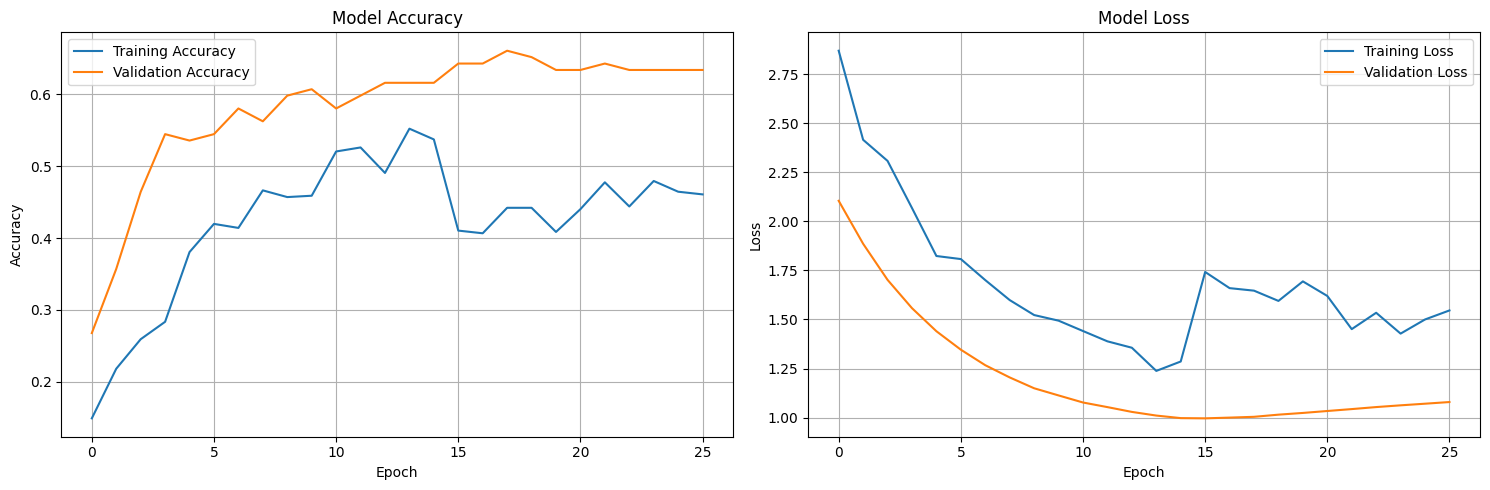

In [30]:
# %%
# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    axes[0].plot(history['accuracy'], label='Training Accuracy')
    axes[0].plot(history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history['loss'], label='Training Loss')
    axes[1].plot(history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(combined_history)

In [31]:
# %%
# Evaluate model
print("=== MODEL EVALUATION ===")

# Load best model
best_model = keras.models.load_model(str(MODELS_DIR / 'best_model.h5'))

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

=== MODEL EVALUATION ===


4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5812 - loss: 1.0602
Test Accuracy: 0.5812
Test Loss: 1.0602


In [24]:
# %%
# Predictions
y_true = test_generator.classes
y_pred_proba = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step


In [32]:
# %%
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

Classification Report:
                 precision    recall  f1-score   support

  tomato_unripe       0.89      0.62      0.73        13
    tomato_ripe       0.47      0.58      0.52        12
tomato_overripe       0.64      0.50      0.56        14
   mango_unripe       0.50      0.71      0.59        14
     mango_ripe       0.50      0.67      0.57        12
 mango_overripe       0.71      0.50      0.59        10
  banana_unripe       0.60      0.80      0.69        15
    banana_ripe       0.45      0.36      0.40        14
banana_overripe       0.75      0.46      0.57        13

       accuracy                           0.58       117
      macro avg       0.61      0.58      0.58       117
   weighted avg       0.61      0.58      0.58       117



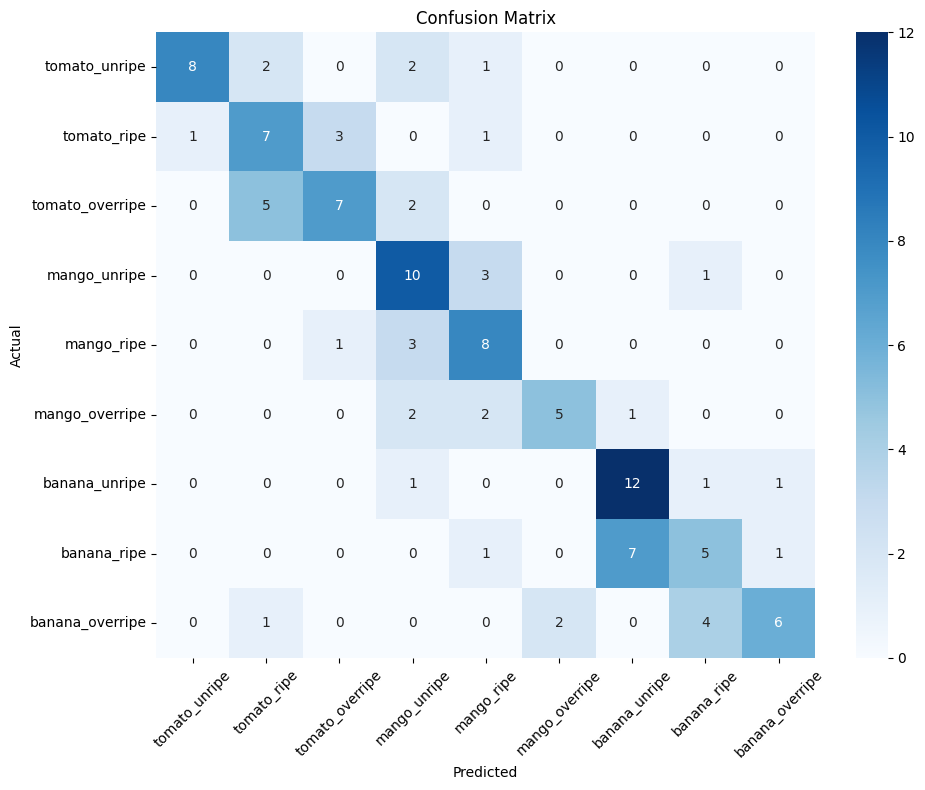

In [33]:
# %%
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [34]:
# %%
# Save final model
model.save(str(MODELS_DIR / 'final_model.h5'))
print("Final model saved!")

Final model saved!


In [35]:
# %%
# Save training history
training_results = {
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'training_history': combined_history,
    'config': config
}

with open(RESULTS_DIR / 'training_results.json', 'w') as f:
    json.dump(training_results, f, indent=2)

print("Training completed and results saved!")

Training completed and results saved!
